In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore")
import pyreadr
import random
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pyreadr.read_r('I80_1st15minutes_complete.rds')
df= df[None]


In [3]:
df["Vehicle.ID"]=df["Vehicle.ID"].astype(str)
df["Preceding.Vehicle.ID"]=df["Preceding.Vehicle.ID"].astype(str)
df["LF_pairs"] = df["Preceding.Vehicle.ID"]+ "_"+ df["Vehicle.ID"]

In [4]:
df["nextframeAcc"]=df.groupby(["LF_pairs"],as_index=False)["sacc"].shift(-1)
df["nextframesvel"]=df.groupby(["LF_pairs"],as_index=False)["svel"].shift(-1)
df["nextframeposition"]=df.groupby(["LF_pairs"],as_index=False)["Local.Y"].shift(-1)

In [5]:
df['Pair_Time_Duration']=(df.groupby(['LF_pairs'],as_index=False).cumcount()*0.1) +0.1

In [6]:
df = df[df["PrecVehClass"].notna()]

df = df[df["svel"].notna()]

df = df[df["spacing"].notna()]

df = df[df["frspacing"].notna()]

df = df[df["Local.Y"].notna()]

df = df[df["nextframeAcc"].notna()]

df = df[df["Pair_Time_Duration"].notna()]

df = df[df["nextframeposition"].notna()]

df = df[df["nextframesvel"].notna()]

In [7]:
df['PrecVehType'] = df['PrecVehType'].map({'Motorcycle': 1, 'Car': 2, 'Heavy-Vehicle': 3})
df['Vehicle.type'] = df['Vehicle.type'].map({'Motorcycle': 1, 'Car': 2, 'Heavy-Vehicle': 3})

In [8]:
def training_pairs(data):
    random.seed(2109)
    pairs = data["LF_pairs"].unique()
    pairs = pairs.tolist()
    v = round(len(pairs)*0.7)   
    pairs = random.sample(pairs, v)
    return pairs
my_pairs=training_pairs(df)
#converting the total dataset to 70/30% pair for train and test. 
train = df[df['LF_pairs'].isin(my_pairs)]

test = df[~df['LF_pairs'].isin(my_pairs)]

In [9]:
X_train = train[["spacing",'PrecVehType','Vehicle.type','dV','svel']]
y_train= train['nextframeAcc']
X_test = test[["spacing",'PrecVehType','Vehicle.type','dV','svel']]
y_test= test['nextframeAcc']
rf = RandomForestRegressor(n_estimators = 150,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=150, n_jobs=-1)

In [10]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['LF_pairs'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['LF_pairs']== i]
        vel=np.zeros(Q.shape[0])
        PrecVehType =  np.zeros(Q.shape[0])
        FollVehtype = np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])
        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['svel']
        PrecVehType[0]=Q.iloc[0]['PrecVehType']
        FollVehtype[0] = Q.iloc[0]['Vehicle.type']
        spacing[0] = Q.iloc[0]['spacing']
        
        dv[0] = Q.iloc[0]['dV']   
        #pred_speed[0] = Q.iloc[0]['svel']
    #?? verify this     
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(2,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j]*0.1)
            dv[j] = vel[j] - Q.iloc[j]['PrecVehVel']
            spacing[j] = spacing[j-1]+((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2)))
            PrecVehType[j]= PrecVehType[j-1]
            FollVehtype[j]=FollVehtype[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc']=pred_acc
        Q['pvel']=vel
        Q['PrecVehType']= PrecVehType
        Q['FollVehtype']= FollVehtype
        Q['pdv']= dv
        Q['spacing']=spacing

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [11]:
c, b = data_in_parts(test,0,6)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, b, target_variable, rf)

['3355_1', '17_12', '15_13', '27_31', '25_39', '13_41']


In [12]:
F

,Vehicle.ID,Frame.ID,Lane,Local.Y,svel,sacc,Vehicle.Length,Vehicle.class,Following.Vehicle.ID,Preceding.Vehicle.ID,...,dA,LF_pairs,nextframeAcc,nextframesvel,nextframeposition,Pair_Time_Duration,pacc,pvel,FollVehtype,pdv
334,1,481,2,173.27443,6.94512,-0.96402,4.3591,2,11,3355,...,0.65758,3355_1,-1.20074,6.82504,173.95693,0.1,-1.398330,6.945120,2.0,-2.068960
335,1,482,2,173.95693,6.82504,-1.20074,4.3591,2,11,3355,...,0.01280,3355_1,-1.39833,6.68521,174.62545,0.2,-0.604334,0.000000,0.0,0.000000
336,1,483,2,174.62545,6.68521,-1.39833,4.3591,2,11,3355,...,-0.56450,3355_1,-1.46441,6.53877,175.27933,0.3,0.000000,0.000000,0.0,-8.809350
337,1,484,2,175.27933,6.53877,-1.46441,4.3591,2,11,3355,...,-0.91793,3355_1,-1.34976,6.40379,175.91971,0.4,0.974022,0.097402,0.0,-8.657298
338,1,485,2,175.91971,6.40379,-1.34976,4.3591,2,11,3355,...,-0.99473,3355_1,-1.08862,6.29493,176.54920,0.5,0.974022,0.194804,0.0,-8.524396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10892,41,943,4,427.60260,7.17603,0.09644,4.2067,2,67,13,...,-0.45737,13_41,0.30648,7.20667,428.32326,24.5,1.681044,0.303097,0.0,-6.172273
10893,41,944,4,428.32326,7.20667,0.30648,4.2067,2,67,13,...,-0.22560,13_41,0.20634,7.22731,429.04599,24.6,1.708114,0.473908,0.0,-6.054672
10894,41,945,4,429.04599,7.22731,0.20634,4.2067,2,67,13,...,-0.38150,13_41,-0.22472,7.20484,429.76648,24.7,1.643074,0.638216,0.0,-5.949154
10895,41,946,4,429.76648,7.20484,-0.22472,4.2067,2,67,13,...,-0.85150,13_41,-0.84783,7.12005,430.47848,24.8,1.564687,0.794685,0.0,-5.855355


In [13]:
F1 = F[F["LF_pairs"] == "15_13"]

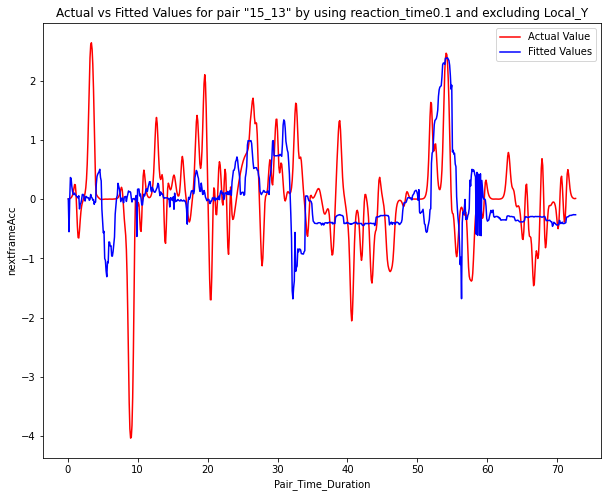

In [21]:
import seaborn as sns
plt.figure(figsize=(10, 8))


ax = sns.lineplot(x=F1["Pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["Pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values for pair "15_13" by using reaction_time0.1 and excluding Local_Y')


plt.show()
plt.close()

In [16]:
def accuracy(F):
    mae_score = mean_absolute_error(F['sacc'], F['pacc'])
    r2_scores = r2_score(F['sacc'], F['pacc'])
    return mae_score, r2_scores

In [19]:
accuracy(F)

(0.7604026008551992, -0.25026994751800813)

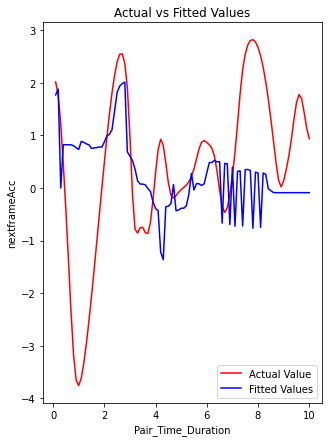

In [63]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F2["Pair_Time_Duration"], y = F2["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F2["Pair_Time_Duration"], y =F2["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [71]:
F0 = F[F["LF_pairs"] == "3355_1"]

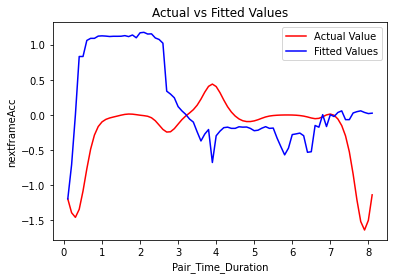

In [72]:
ax = sns.lineplot(x=F0["Pair_Time_Duration"], y = F0["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F0["Pair_Time_Duration"], y =F0["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [81]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['LF_pairs'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['LF_pairs']== i]
        vel=np.zeros(Q.shape[0])
        PrecVehType =  np.zeros(Q.shape[0])
        FollVehtype = np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])
        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['svel']
        PrecVehType[0]=Q.iloc[0]['PrecVehType']
        FollVehtype[0] = Q.iloc[0]['Vehicle.type']
        spacing[0] = Q.iloc[0]['spacing']
        
        dv[0] = Q.iloc[0]['dV']   
        #pred_speed[0] = Q.iloc[0]['svel']
    #?? verify this     
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(2,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j]*0.1)
            dv[j] = vel[j] - Q.iloc[j]['PrecVehVel']
            spacing[j] = ((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2))) ############################################################
            PrecVehType[j]= PrecVehType[j-1]
            FollVehtype[j]=FollVehtype[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc1']=pred_acc

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [87]:
c, b = data_in_parts(test,0,5)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, b, target_variable, rf)

['3355_1', '17_12', '15_13', '27_31', '25_39']


In [92]:
F["LF_pairs"].unique()

array(['3355_1', '17_12', '15_13', '27_31', '25_39'], dtype=object)

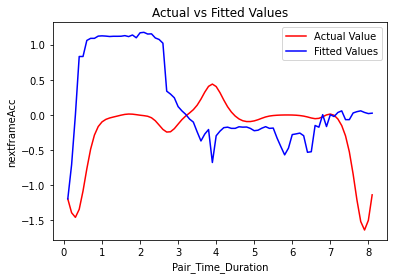

In [83]:
ax = sns.lineplot(x=F0["Pair_Time_Duration"], y = F0["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F0["Pair_Time_Duration"], y =F0["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [93]:
F00 = F[F["LF_pairs"] == "15_13"]

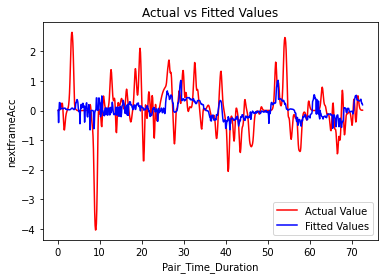

In [94]:
ax = sns.lineplot(x=F00["Pair_Time_Duration"], y = F00["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F00["Pair_Time_Duration"], y =F00["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()